In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from HelperAndMechanics import *
from matplotlib import cm
from ipywidgets import *
import seaborn as sns
import pandas as pd

# Set Palatino as the default font
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

In [2]:
import h5py
import numpy as np

def list_groups(file_path):
    """Returns a list of the first-layer group names in an HDF5 file (direct children of root)."""
    with h5py.File(file_path, 'r') as f:
        return [name for name in f if isinstance(f[name], h5py.Group)]

def load_run(file_path, run):
    """Reads the data and parameters from a saved HDF5 file."""
    data = {}
    params_dict = {}
    
    with h5py.File(file_path, 'r') as f:
        if run not in f:
            raise ValueError(f"Run '{run}' not found in file.")
        
        group = f[run]
        
        # Load datasets (if available)
        dataset_keys = ['u_sol', 'u', 'v_sol', 'v', 'T_sol', 'T', 'x_sol', 'x',
                        'u_BOCF', 'v_BOCF', 'T_BOCF', 'x_BOCF']
        
        for key in dataset_keys:
            if key in group:
                data[key] = np.array(group[key])
        
        # Load attributes from 'params_train' subgroup
        if "params_train" in group:
            params_group = group["params_train"]
            params_dict = {key: params_group.attrs[key] for key in params_group.attrs}
    
    return data, params_dict

def load_stat_data(file_path, mode='AP_AP'):
    """
    Load the data from the HDF5 file and return the datasets and parameters.
    
    Parameters:
        file_path (str): Path to the HDF5 file.
        mode (str): Mode of operation ('AP_AP' or 'BOCF').
    
    Returns:
        u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, params
    """
    run_list = list_groups(file_path)
    print("Available runs:", len(run_list))

    # Initialize storage lists
    u_sol, u_sim = [], []
    v_sol, v_sim = [], []
    T_sol, T_sim = [], []
    x_sol, x_sim = [], []
    params = {}

    for run in run_list:
        data, params_train = load_run(file_path, run)

        if not params:  # Initialize parameter dictionary once
            params = {key: [] for key in params_train.keys()}

        if mode == 'AP_AP':
            u_sol.append(data.get('u_sol', np.array([])))
            u_sim.append(data.get('u', np.array([])))
            v_sol.append(data.get('v_sol', np.array([])))
            v_sim.append(data.get('v', np.array([])))
            T_sol.append(data.get('T_sol', np.array([])))
            T_sim.append(data.get('T', np.array([])))
            x_sol.append(data.get('x_sol', np.array([])))
            x_sim.append(data.get('x', np.array([])))

        elif mode == 'BOCF':
            u_sol.append(data.get('u_sol', np.array([])))
            u_sim.append(data.get('u_BOCF', np.array([])))
            v_sol.append(data.get('v_sol', np.array([])))
            v_sim.append(data.get('v_BOCF', np.array([])))
            T_sol.append(data.get('T_sol', np.array([])))
            T_sim.append(data.get('T_BOCF', np.array([])))
            x_sol.append(data.get('x_sol', np.array([])))
            x_sim.append(data.get('x_BOCF', np.array([])))

        # Append parameters
        for key in params_train.keys():
            params[key].append(params_train[key])

    # Convert lists to NumPy arrays
    return (
        np.concatenate(u_sol) if u_sol else np.array([]),
        np.concatenate(u_sim) if u_sim else np.array([]),
        np.concatenate(v_sol) if v_sol else np.array([]),
        np.concatenate(v_sim) if v_sim else np.array([]),
        np.concatenate(T_sol) if T_sol else np.array([]),
        np.concatenate(T_sim) if T_sim else np.array([]),
        np.concatenate(x_sol) if x_sol else np.array([]),
        np.concatenate(x_sim) if x_sim else np.array([]),
        {key: np.array(val) for key, val in params.items()}
    )

def violin_plot(file_path, mode, selected_keys,params_true):
    """
    Generates a violin plot for selected parameters normalized by their true values.

    Parameters:
        file_path (str): Path to the HDF5 file.
        mode (str): Mode of operation ('AP_AP' or 'BOCF').
        selected_keys (list): List of parameter names to include in the plot.
    """
    # Load data
    _, _, _, _, _, _, _, _, params = load_stat_data(file_path, mode)


    # Normalize selected parameters
    normalized_params = {}
    for key in selected_keys:
        if key in params and key in params_true:
            normalized_params[key] = params[key] / params_true[key]
    
    # Convert to DataFrame
    df = pd.DataFrame(normalized_params)

    # Create the violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=df, inner="quartile", palette="coolwarm")
    sns.stripplot(data=df, color='black', jitter=True, alpha=0.5, zorder=3)  # Individual data points

    # Add grid in the background
    plt.grid(True, linestyle="--", alpha=0.6, zorder=0)
    # Add horizontal line at y=1
    # plt.axhline(y=1, linestyle="-",color='black', linewidth=1, zorder=1, label="True Value")
    # Labels and title
    plt.xticks(rotation=45)
    plt.title(f"Normalized Parameters")
    # plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')

    # Show the plot
    plt.show()

def plot_T_error(file_path,run,params,params_true,mode ='AP_AP'):
    """
    Plots the comparison of reconstructed and simulated u variables for a given run.
    """
    u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, params = load_stat_data(file_path, mode='AP_AP')

    l_a_sol = ((params['n_0'][run]-params['l_0'][run]/2)**2+(params['l_0'][run]/2)**2)**(1/2)
    l_a_sim = ((params_true['n_0']-params_true['l_0']/2)**2+(params_true['l_0']/2)**2)**(1/2)

    

    print("T_sol shape:", T_sol.shape)
    for frame in range(0, T_sol.shape[1], 5):
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))

        # Define common vmin and vmax for consistent colormap scaling
        l_a_effective_sol = l_a_sol / (1+params['c_a'][run]*T_sol)
        l_a_effective_sim = l_a_sim / (1+params_true['c_a']*T_sim)        
        vmin, vmax = 0,np.max([l_a_effective_sim,l_a_effective_sol])#min(u_sol[run].min(), u_sim[run].min()), max(u_sol[run].max(), u_sim[run].max())

        print("l_a_effective_sol shape:", l_a_effective_sol.shape)
        im = ax[0].imshow(l_a_effective_sol[run, frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
        if frame == 0:
            ax[0].set_title('Reconstructed l_a')
        ax[0].axis('off')
        # fig.colorbar(im, ax=ax[0])

        # Simulated u
        im = ax[1].imshow(l_a_effective_sim[run, frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
        if frame == 0:
            ax[1].set_title('Simulated u')
        ax[1].axis('off')
        # fig.colorbar(im, ax=ax[1])

        # Absolute Error
        im = ax[2].imshow(np.abs(l_a_effective_sol[run, frame] - l_a_effective_sim[run, frame]), cmap='coolwarm', vmin=0, vmax=vmax)
        if frame == 0:
            ax[2].set_title('Abs. Error')
        ax[2].axis('off')
        # fig.colorbar(im, ax=ax[2])
        if frame == 0:
            fig.suptitle('Reconstruction of u Variable', fontsize=plt.rcParams['axes.titlesize'], fontweight='bold')
        
        
        plt.show()
        plt.close(fig)  # Prevent memory buildup
        
    mean_err_over_time = np.mean((T_sol - T_sim) ** 2, axis=(1,2, 3)) / np.mean(T_sol ** 2, axis=(1,2, 3))
    print("Mean Squared Error:", mean_err_over_time[run])

def plot_u_error(file_path,run,mode='AP_AP'):
    """
    Plots the comparison of reconstructed and simulated u variables for a given run.
    """
    u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, params = load_stat_data(file_path, mode='AP_AP')
    print("u_sol shape:", u_sol.shape)
    for frame in range(0, u_sol.shape[1], 5):
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))

        # Define common vmin and vmax for consistent colormap scaling
        vmin, vmax = 0,1#min(u_sol[run].min(), u_sim[run].min()), max(u_sol[run].max(), u_sim[run].max())

        # Reconstructed u
        im = ax[0].imshow(u_sol[run, frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
        if frame == 0:
            ax[0].set_title('Reconstructed u')
        ax[0].axis('off')
        # fig.colorbar(im, ax=ax[0])

        # Simulated u
        im = ax[1].imshow(u_sim[run, frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
        if frame == 0:
            ax[1].set_title('Simulated u')
        ax[1].axis('off')
        # fig.colorbar(im, ax=ax[1])

        # Absolute Error
        im = ax[2].imshow(np.abs(u_sol[run, frame] - u_sim[run, frame]), cmap='coolwarm', vmin=0, vmax=1)
        if frame == 0:
            ax[2].set_title('Abs. Error')
        ax[2].axis('off')
        # fig.colorbar(im, ax=ax[2])
        if frame == 0:
            fig.suptitle('Reconstruction of u Variable', fontsize=plt.rcParams['axes.titlesize'], fontweight='bold')
        
        
        plt.show()
        plt.close(fig)  # Prevent memory buildup
        
    mean_err_over_time = np.mean((u_sol - u_sim) ** 2, axis=(1,2, 3)) / np.mean(u_sol ** 2, axis=(1,2, 3))
    print("Mean Squared Error:", mean_err_over_time[run])

def plot_u_mse_over_time(file_path):

    u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, params = load_stat_data(file_path, mode='AP_AP')

    # Compute mean squared error over the last two axes (assuming shape: (runs, time_steps, 100, 100))
    mean_err_over_time = np.mean((u_sol - u_sim) ** 2, axis=(2, 3)) / np.mean(u_sol ** 2, axis=(2, 3))
    time = np.linspace(0, mean_err_over_time.shape[1], mean_err_over_time.shape[1])
    # Plot all runs with different colors
    plt.figure(figsize=(8, 5))
    for run in range(mean_err_over_time.shape[0]):
        plt.plot(time,mean_err_over_time[run], alpha=0.7)

    # Formatting
    plt.xlabel('Time')
    plt.ylabel('Normalized MSE')
    plt.title('Mean Squared Error of u Over Time')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Optional: Use log scale if values span multiple orders of magnitude
    plt.yscale('log')

    plt.show()

In [3]:
a = {'a': 1, 'b': 2, 'c': 3}
a.pop('a')  # Remove the key 'a'
print(a)  # Output: {'b': 2, 'c': 3}

{'b': 2, 'c': 3}


# non-Isotropic Fiber Orientation

In [4]:
file_path_APAP_etavar = '../data/SpringMassModel/FullDomain/FitAllParams/Stats/FullDomain_len15_lr15_tol099_keepdataTrue_keepparamsTrue_etavarTrue_modechaos.h5'
mode = 'AP_AP'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, params = load_stat_data(file_path_APAP_etavar, mode)
print(u_sol.shape)
print("Mean Squared Errors:")
print("u:", np.mean((u_sol - u_sim)**2)/np.mean(u_sol**2))
print("v:", np.mean((v_sol - v_sim)**2)/np.mean(v_sol**2))
print("T:", np.mean((T_sol - T_sim)**2)/np.mean(T_sol**2))

Available runs: 35
(35, 15, 100, 100)
Mean Squared Errors:
u: 0.19738175900401317
v: 0.28769426096292505
T: 1.0128611046398548


In [5]:
keys =['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing','D','a','k','mu_1','mu_2','epsilon_0','spacing']
N,size,params_true = read_config(['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing','D','a','k','mu_1','mu_2','epsilon_0','spacing'],mode = 'chaos')
params_true = dict(zip(keys,params_true))
keys =['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing','D','a','k','mu_1','mu_2','epsilon_0','spacing']
N_scroll,size_scroll,params_true_scroll = read_config(['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing','D','a','k','mu_1','mu_2','epsilon_0','spacing'],mode = 'scroll')
params_true_scroll = dict(zip(keys,params_true_scroll))

params_true['D1'] = params_true['D'] *1/3
params_true['D2'] = params_true['D'] 
mech_keys = ['c_damp','k_ij','k_a','k_j','l_0','c_a','k_T','n_0']
electric_keys = ['D','a','k','mu_1','mu_2','epsilon_0','spacing']
electric_keys_2diff = ['D1','D2','a','k','mu_1','mu_2','epsilon_0','spacing']

gaussian_keys = [f'Amp{i}{j}' for i in range(3) for j in range(3)]
for key in gaussian_keys:
    params_true[key] = 1

In [6]:
run = 0  # Ensure 'un' or 'run' is used consistently
# plot_u_error(file_path_APAP_etavar, run)
# plot_T_error(file_path_APAP_etavar, run, params, params_true , mode)

Available runs: 35


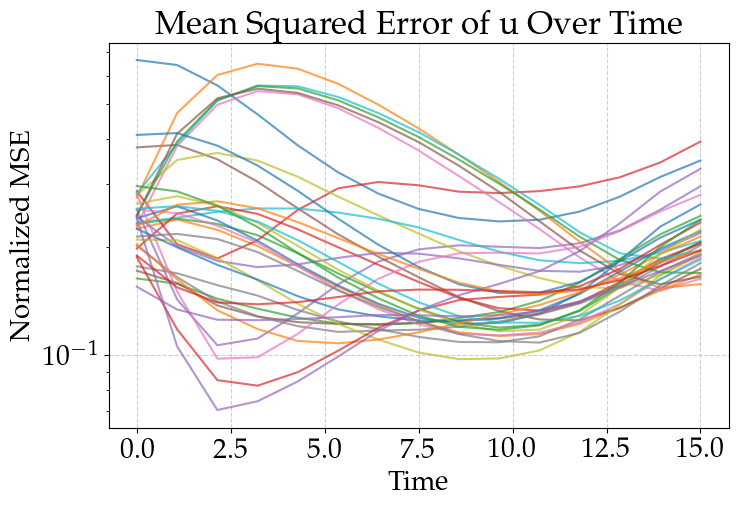

Available runs: 35


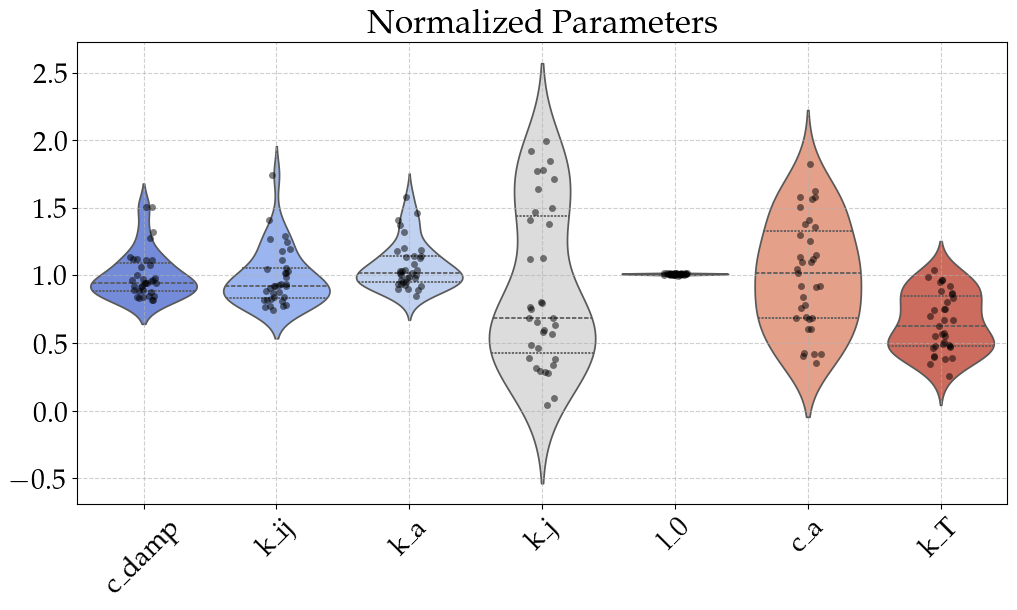

In [7]:
plot_u_mse_over_time(file_path_APAP_etavar)
new_mech_keys = [k for k in mech_keys if k != 'n_0']
violin_plot(file_path_APAP_etavar, mode="AP_AP", selected_keys=new_mech_keys,params_true=params_true)
# violin_plot(file_path_APAP_etavar, mode="AP_AP", selected_keys=electric_keys,params_true=params_true)
# violin_plot(file_path_APAP_etavar, mode="AP_AP", selected_keys=gaussian_keys,params_true=params_true)

# Isotropic Fiber Orientation

In [10]:
file_path_APAP_eta05 = '../data/SpringMassModel/FullDomain/FitAllParams/Stats/FullDomain_len15_lr15_tol099_keepdataTrue_keepparamsTrue_etavarFalse_modechaos.h5'
mode = 'AP_AP'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, params = load_stat_data(file_path_APAP_eta05, mode)
print("Normalized Mean Squared Errors:")
print("u:", np.mean((u_sol - u_sim)**2)/np.mean(u_sol**2))
print("v:", np.mean((v_sol - v_sim)**2)/np.mean(v_sol**2))
print("T:", np.mean((T_sol - T_sim)**2)/np.mean(T_sol**2))

Available runs: 0
Normalized Mean Squared Errors:
u: nan
v: nan
T: nan


In [12]:
run=2
# plot_u_error(file_path_APAP_eta05, run)

In [13]:
plot_u_mse_over_time(file_path_APAP_eta05)
violin_plot(file_path_APAP_eta05, mode="AP_AP", selected_keys=mech_keys,params_true=params_true)
violin_plot(file_path_APAP_eta05, mode="AP_AP", selected_keys=electric_keys,params_true=params_true)

Available runs: 0


AxisError: axis 2 is out of bounds for array of dimension 1

# Keep Electric Params True

In [ ]:
file_path_APAPtrue_eta05 = '../data/SpringMassModel/FullDomain/TrueElectricParams/Stats/FullDomain_len15_lr15_tol099_keepdataTrue_keepparamsTrue_etavarFalse.h5'
mode = 'AP_AP'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, params = load_stat_data(file_path_APAPtrue_eta05, mode)
print("Normalized Mean Squared Errors:")
print("u:", np.mean((u_sol - u_sim)**2)/np.mean(u_sol**2))
print("v:", np.mean((v_sol - v_sim)**2)/np.mean(v_sol**2))
print("T:", np.mean((T_sol - T_sim)**2)/np.mean(T_sol**2))

Available runs: 28
Normalized Mean Squared Errors:
u: 0.08430552196318072
v: 0.19258014312420413
T: 0.23617826885585042


In [ ]:
run=1
# plot_u_error(file_path_APAPtrue_eta05, run)

Available runs: 28


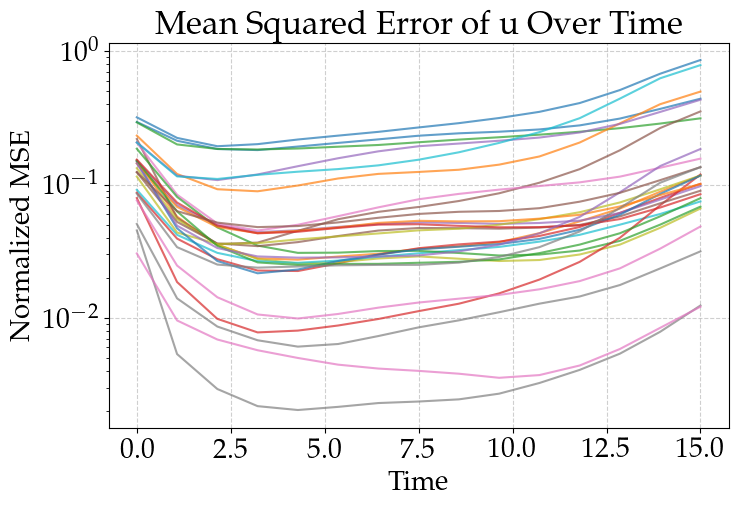

Available runs: 28


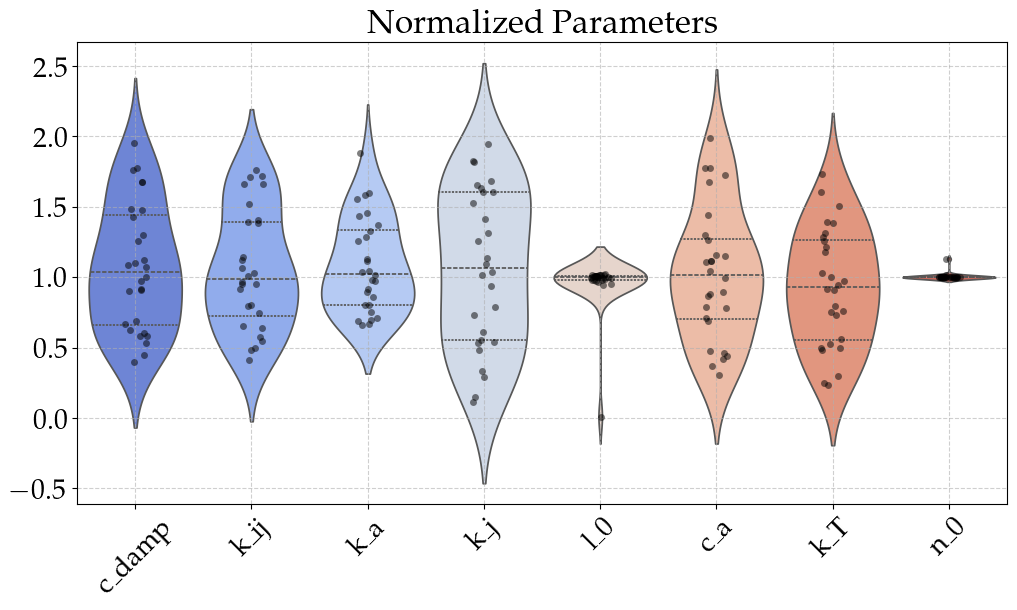

In [ ]:
plot_u_mse_over_time(file_path_APAPtrue_eta05)
violin_plot(file_path_APAPtrue_eta05, mode="AP_AP", selected_keys=mech_keys,params_true=params_true)

# Include m in Parameter Reconstruction

In [ ]:
file_path = '../data/SpringMassModel/FullDomain/FitAllParams/Stats/FullDomain_len15_lr15_tol099_keepdataTrue_keepparamsTrue_etavarFalse_m.h5'
mode = 'AP_AP'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, params = load_stat_data(file_path, mode)
print("Normalized Mean Squared Errors:")
print("u:", np.mean((u_sol - u_sim)**2)/np.mean(u_sol**2))
print("v:", np.mean((v_sol - v_sim)**2)/np.mean(v_sol**2))
print("T:", np.mean((T_sol - T_sim)**2)/np.mean(T_sol**2))

Available runs: 26
Normalized Mean Squared Errors:
u: 0.15971675045190106
v: 0.36326364555172175
T: 0.2813382580268396


In [ ]:
run=3
# plot_u_error(file_path, run)

Available runs: 26


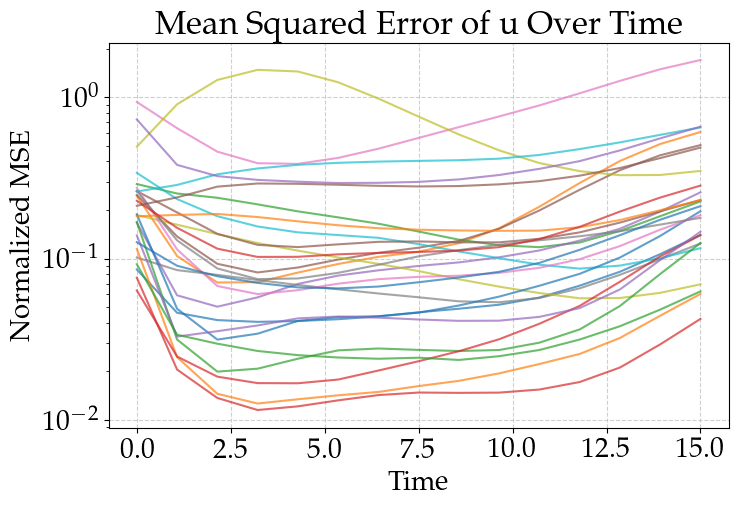

Available runs: 26


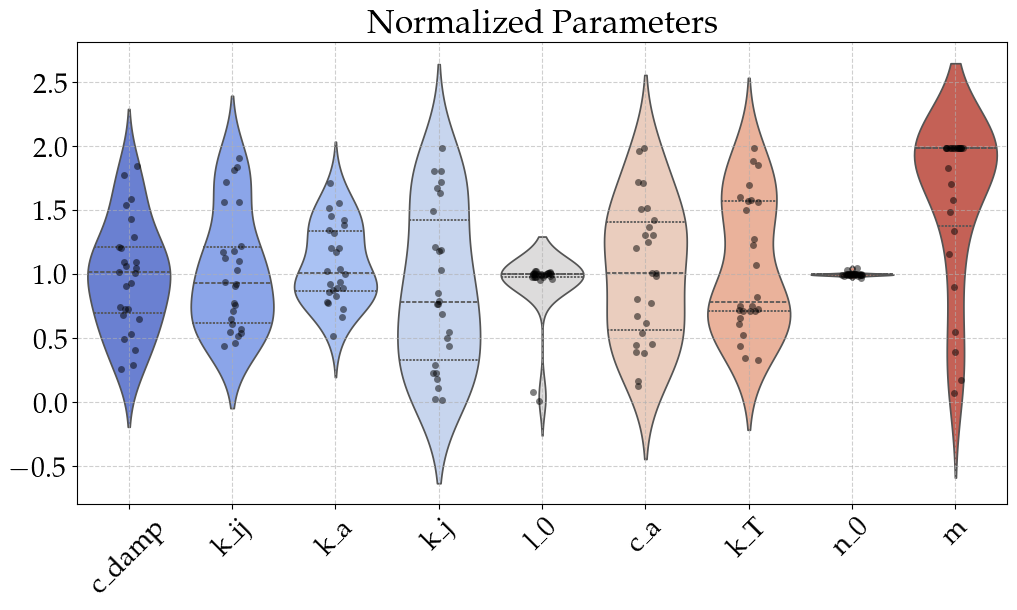

Available runs: 26


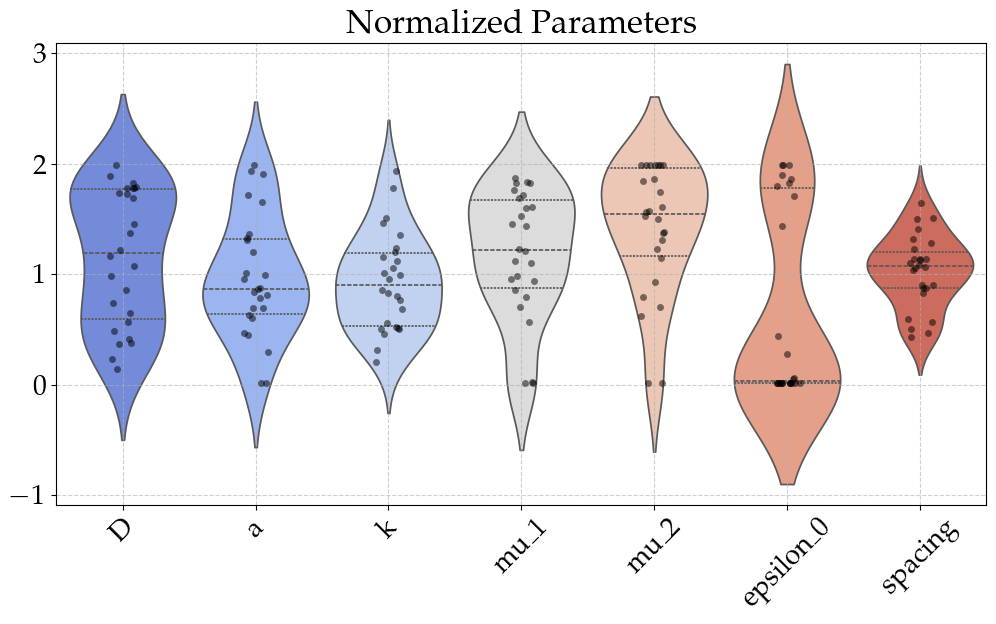

In [ ]:
plot_u_mse_over_time(file_path)
violin_plot(file_path, mode="AP_AP", selected_keys=mech_keys+['m'],params_true=params_true)
violin_plot(file_path, mode="AP_AP", selected_keys=electric_keys,params_true=params_true)

# 2 Diffusion directions Isotropic

In [32]:
file_path_APAP_2Diff = '../data/SpringMassModel/FullDomain/FastSlowDiffIsotropic/Stats/FullDomain_len15_lr15_tol099_keepdataTrue_keepparamsTrue_etavarFalse.h5'
mode = 'AP_AP'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, params = load_stat_data(file_path_APAP_2Diff, mode)
print("Normalized Mean Squared Errors:")
print("u:", np.mean((u_sol - u_sim)**2)/np.mean(u_sol**2))
print("v:", np.mean((v_sol - v_sim)**2)/np.mean(v_sol**2))
print("T:", np.mean((T_sol - T_sim)**2)/np.mean(T_sol**2))


Available runs: 20
Normalized Mean Squared Errors:
u: 0.17650259346149474
v: 0.3766594891887031
T: 0.34675714481588404


Available runs: 20
u_sol shape: (20, 15, 100, 100)


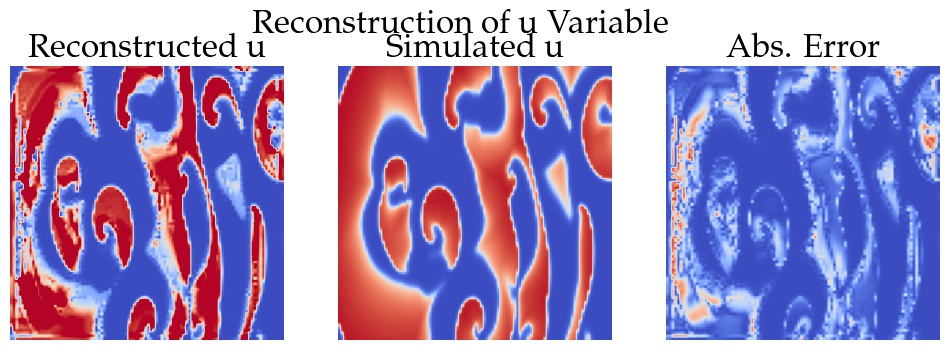

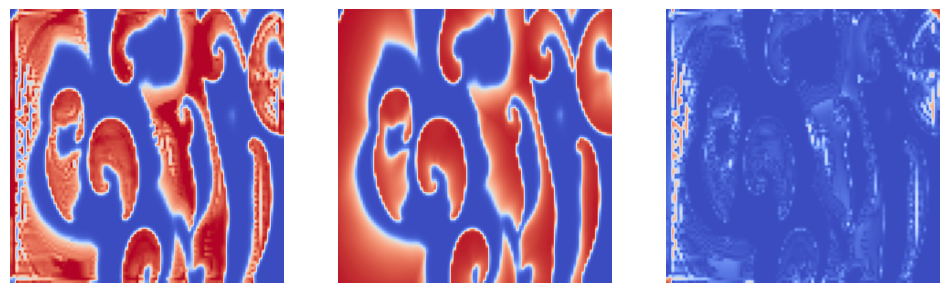

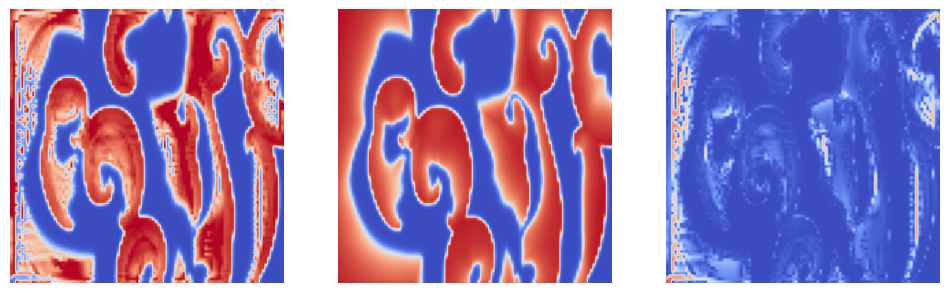

Mean Squared Error: 0.059498665669070354


In [33]:
run = 5
plot_u_error(file_path_APAP_2Diff, run)

Available runs: 20


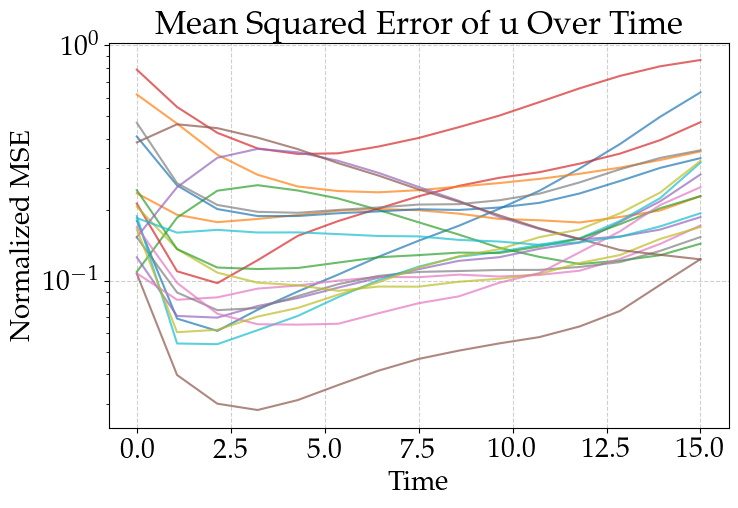

Available runs: 20


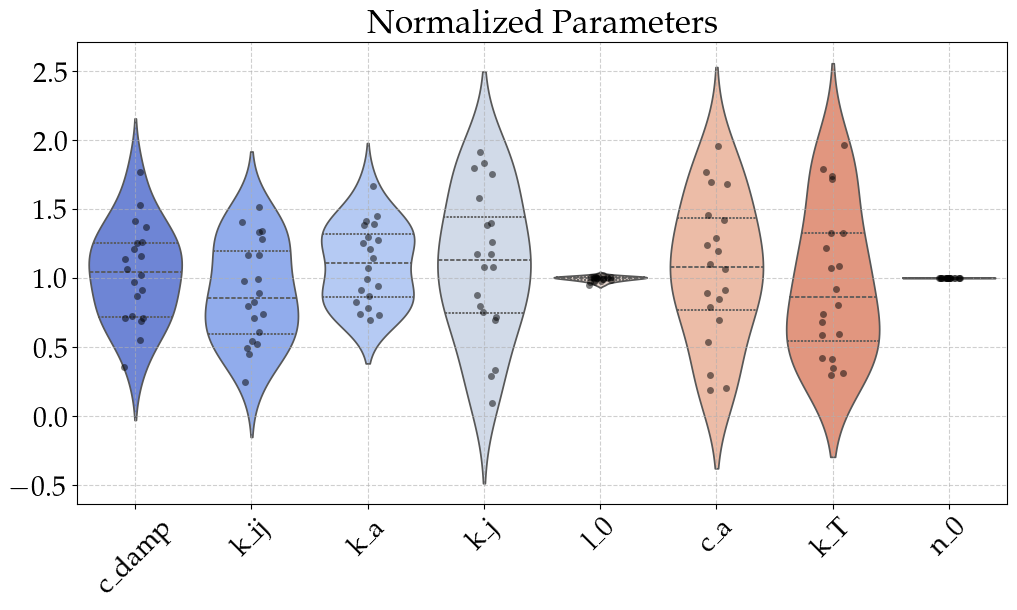

Available runs: 20


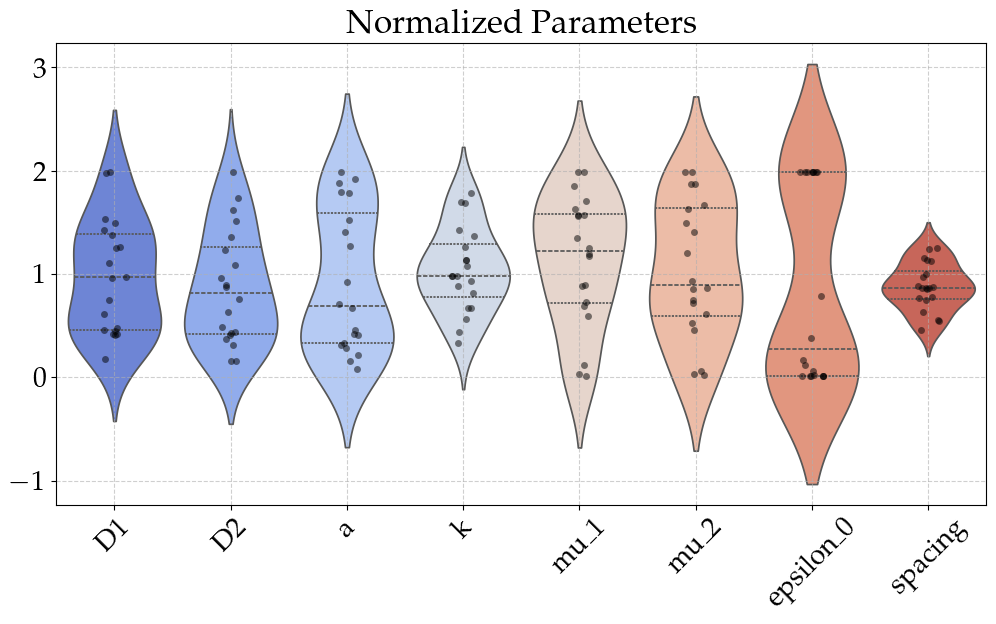

In [34]:
plot_u_mse_over_time(file_path_APAP_2Diff)
violin_plot(file_path_APAP_2Diff, mode="AP_AP", selected_keys=mech_keys,params_true=params_true)
violin_plot(file_path_APAP_2Diff, mode="AP_AP", selected_keys=electric_keys_2diff,params_true=params_true)

# Single Spiral wave

In [70]:
file_path_APAP_spiral = '../data/SpringMassModel/FullDomain/Scroll/FullDomain_len15_lr15_tol099_keepdataTrue_keepparamsTrue_etavarFalse_modescroll.h5'

In [71]:
mode = 'AP_AP'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, params = load_stat_data(file_path_APAP_spiral, mode)
print("Normalized Mean Squared Errors:")
print("u:", np.mean((u_sol - u_sim)**2)/np.mean(u_sol**2))
print("v:", np.mean((v_sol - v_sim)**2)/np.mean(v_sol**2))
print("T:", np.mean((T_sol - T_sim)**2)/np.mean(T_sol**2))

Available runs: 40
Normalized Mean Squared Errors:
u: 0.19123484432064466
v: 0.7239695062146208
T: 0.31360403604685766


In [72]:
params['n_0'][1]

np.float32(0.49979174)

Available runs: 40


u_sol shape: (40, 15, 100, 100)


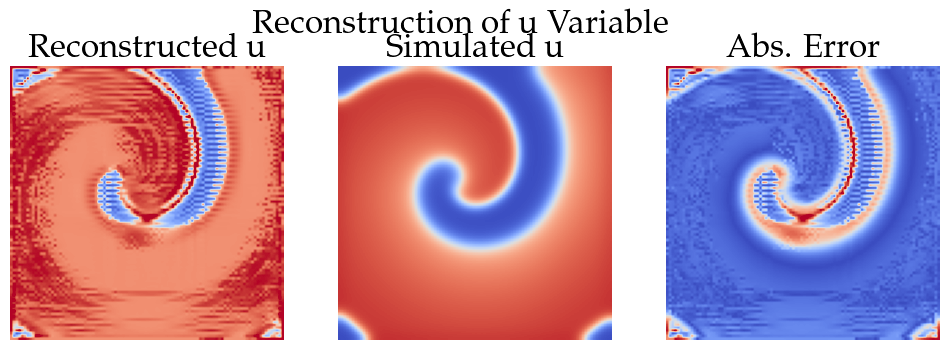

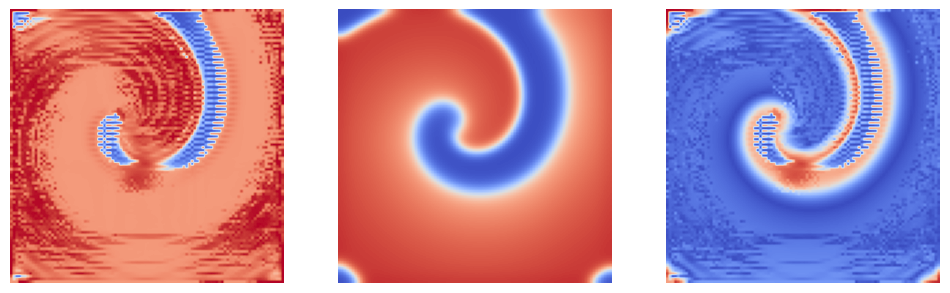

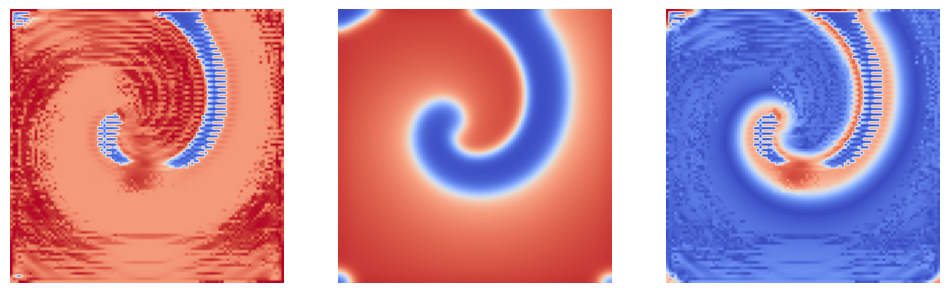

Mean Squared Error: 0.10650639003336748
Available runs: 40
T_sol shape: (40, 15, 100, 100)
l_a_effective_sol shape: (40, 15, 100, 100)


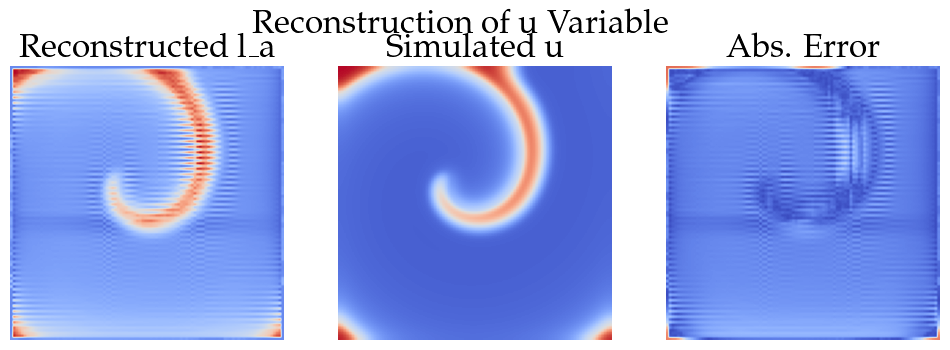

l_a_effective_sol shape: (40, 15, 100, 100)


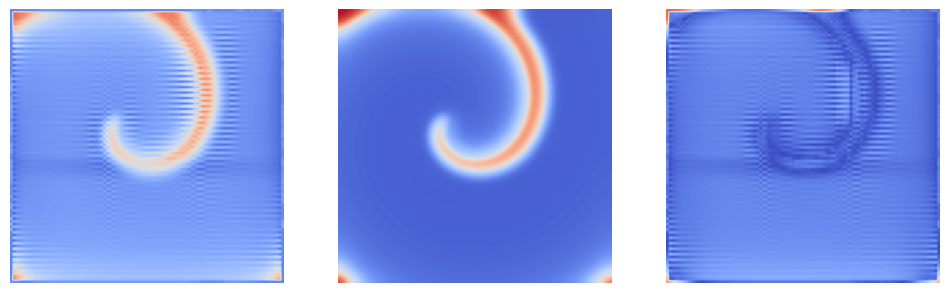

l_a_effective_sol shape: (40, 15, 100, 100)


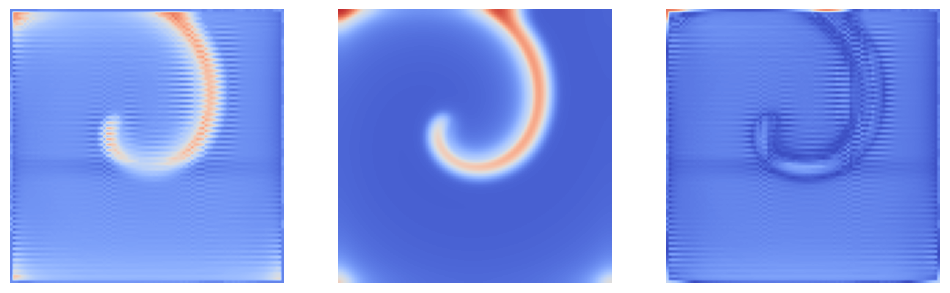

Mean Squared Error: 2.2428452624130437


In [73]:
run = 6
plot_u_error(file_path_APAP_spiral, run)
plot_T_error(file_path_APAP_spiral, run,params,params_true_scroll)

Available runs: 40


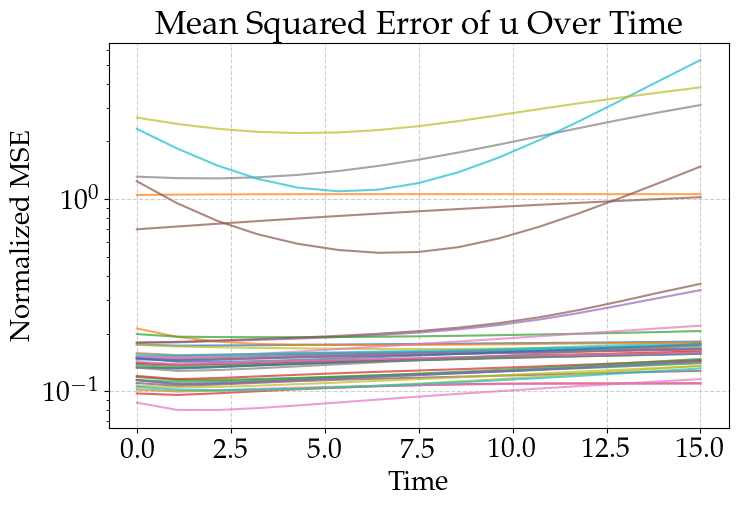

Available runs: 40


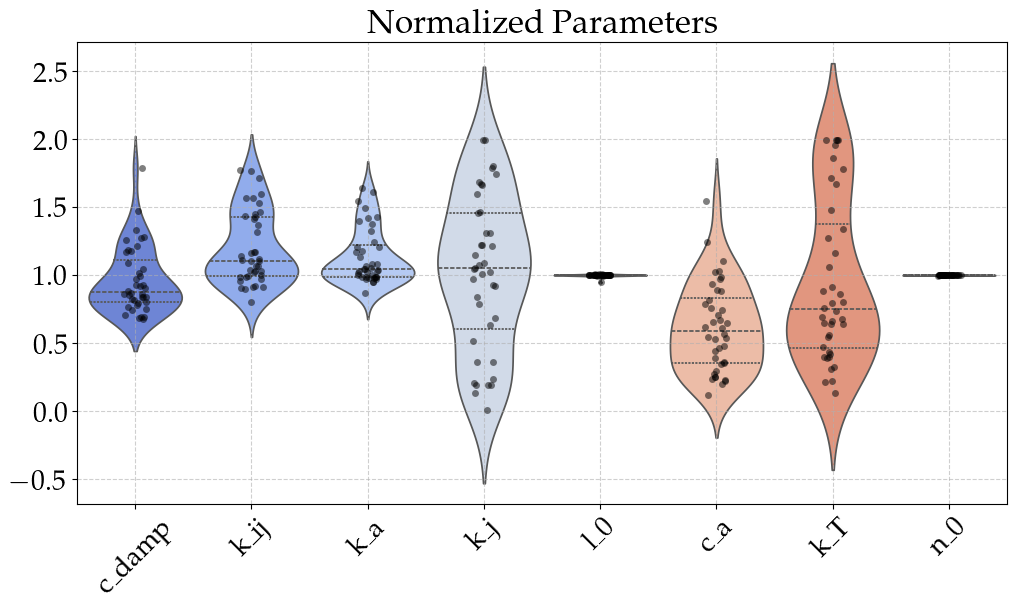

Available runs: 40


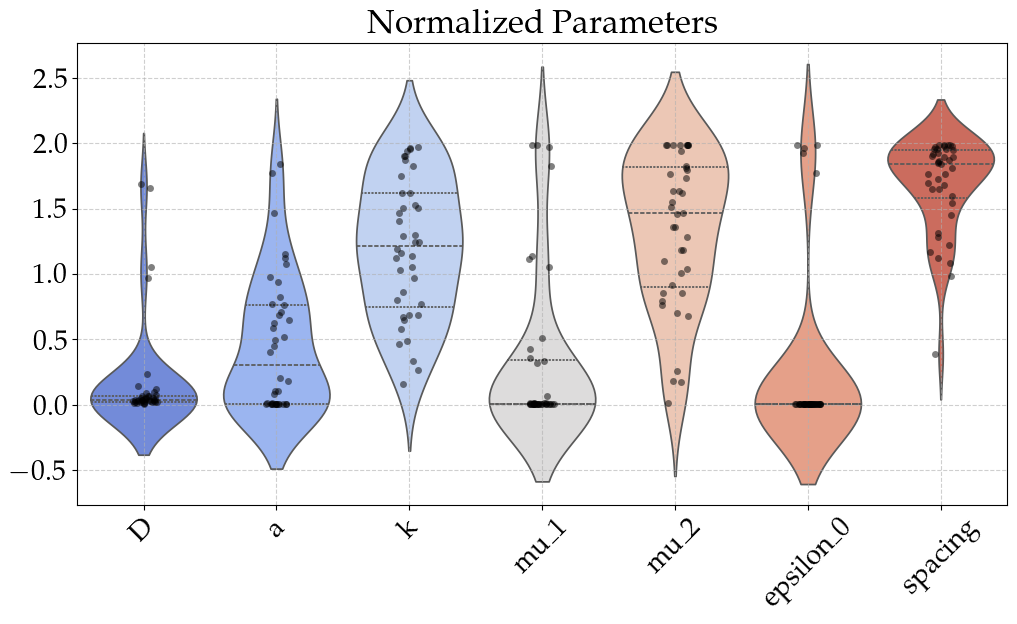

In [67]:

plot_u_mse_over_time(file_path_APAP_spiral)
violin_plot(file_path_APAP_spiral, mode="AP_AP", selected_keys=mech_keys,params_true=params_true_scroll)
violin_plot(file_path_APAP_spiral, mode="AP_AP", selected_keys=electric_keys,params_true=params_true_scroll)

In [40]:
int(np.ceil(15*1/3))

5